## Credit Card Fraud detection
* data from https://www.kaggle.com/mlg-ulb/creditcardfraud

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

card_df = pd.read_csv('creditcard.csv')
card_df.head(3)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


In [2]:
card_df.shape

(284807, 31)

### Make copy of the data set for data preprocessing 

In [3]:
from sklearn.model_selection import train_test_split

def get_preprocessed_df(df=None):
    df_copy = df.copy()
    df_copy.drop('Time', axis=1, inplace = True)
    return df_copy

### Make function that returns train, test dataset

In [4]:
def get_train_test_dataset(df=None):
    df_copy = get_preprocessed_df(df)
    
    X_features = df_copy.iloc[:,:-1]
    y_target = df_copy.iloc[:, -1]
    
    X_train,X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.3, random_state=0, stratify=y_target)
    
    return X_train,X_test, y_train, y_test

X_train,X_test, y_train, y_test = get_train_test_dataset(card_df)

In [5]:
print(y_train.value_counts()/y_train.shape[0]*100)
print(y_test.value_counts()/y_test.shape[0]*100)

0    99.827451
1     0.172549
Name: Class, dtype: float64
0    99.826785
1     0.173215
Name: Class, dtype: float64


In [6]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score

def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    
    roc_auc = roc_auc_score(y_test, pred_proba)
    
    print('confusion matrics')
    print(confusion)
    print('accuracy: {0:.4f}, precision: {1:.4f}, recall: {2:.4f}, F1: {3:.4f}, AUC:{4:.4f}'.format(
    accuracy, precision, recall, f1, roc_auc))

In [7]:
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression()

lr_clf.fit(X_train, y_train)

lr_pred = lr_clf.predict(X_test)
lr_pred_proba = lr_clf.predict_proba(X_test)[:, 1]

get_clf_eval(y_test, lr_pred, lr_pred_proba)

confusion matrics
[[85282    13]
 [   56    92]]
accuracy: 0.9992, precision: 0.8762, recall: 0.6216, F1: 0.7273, AUC:0.9582


### Another function for modeling

In [8]:
def get_model_train_eval(model, ftr_train=None, ftr_test=None, tgt_train=None, tgt_test=None):
    model.fit(ftr_train, tgt_train)
    model_pred = model.predict(ftr_test)
    model_pred_proba = model.predict_proba(ftr_test)[:, 1]
    
    get_clf_eval(tgt_test, model_pred, model_pred_proba)

### LightGBM modeling/evaluation

In [9]:
from lightgbm import LGBMClassifier

# for very unbalanced data, having boost_from_avearge = True results in poor recall & ROC-AUC
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs =-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, X_train, X_test, y_train, y_test)

confusion matrics
[[85289     6]
 [   36   112]]
accuracy: 0.9995, precision: 0.9492, recall: 0.7568, F1: 0.8421, AUC:0.9797


### Adjust dataset distribution

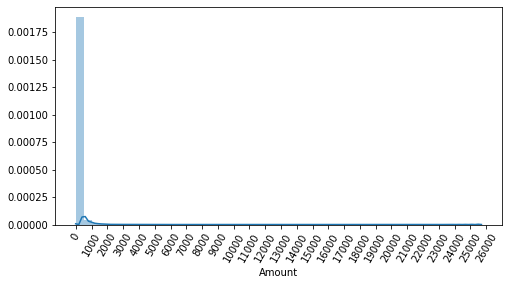

In [10]:
import seaborn as sns

plt.figure(figsize=(8,4))
plt.xticks(range(0,30000, 1000), rotation=60)
sns.distplot(card_df['Amount'])

In [11]:
from sklearn.preprocessing import StandardScaler

def get_preprocessed_df(df=None):
    df_copy = df.copy()
    scaler = StandardScaler()
    # needs to be shaped into (-1, 1) to use scaler
    amount_n=scaler.fit_transform(df_copy['Amount'].values.reshape(-1, 1))
    
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    
    df_copy.drop(['Time','Amount'], axis=1, inplace=True)
    return df_copy

### Logisitic Regression/LGBM modeling after scaling

In [12]:
X_train,X_test, y_train, y_test = get_train_test_dataset(card_df)

print('### LogisticRegression ###')
lr_clf = LogisticRegression()
get_model_train_eval(lr_clf, X_train, X_test, y_train, y_test)

print('### LightGBM ###')
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs =-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, X_train, X_test, y_train, y_test)

### LogisticRegression ###
confusion matrics
[[85281    14]
 [   58    90]]
accuracy: 0.9992, precision: 0.8654, recall: 0.6081, F1: 0.7143, AUC:0.9702
### LightGBM ###
confusion matrics
[[85289     6]
 [   36   112]]
accuracy: 0.9995, precision: 0.9492, recall: 0.7568, F1: 0.8421, AUC:0.9773


### Scale using log

In [13]:
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    
    # log1p = log(x + 1). to reverse, used np.expm1 (exp minus 1)
    amount_n = np.log1p(df_copy['Amount'])
    df_copy.insert(0, "Log_scaled_Amount", amount_n)
    df_copy.drop(['Amount', 'Time'], axis =1, inplace=True)
    return df_copy

In [14]:
X_train,X_test, y_train, y_test = get_train_test_dataset(card_df)

print('### LogisticRegression ###')
lr_clf = LogisticRegression()
get_model_train_eval(lr_clf, X_train, X_test, y_train, y_test)

print('### LightGBM ###')
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs =-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, X_train, X_test, y_train, y_test)

### LogisticRegression ###
confusion matrics
[[85283    12]
 [   59    89]]
accuracy: 0.9992, precision: 0.8812, recall: 0.6014, F1: 0.7149, AUC:0.9727
### LightGBM ###
confusion matrics
[[85290     5]
 [   35   113]]
accuracy: 0.9995, precision: 0.9576, recall: 0.7635, F1: 0.8496, AUC:0.9786


###  get correlation between features, get features with the highest correlation with label

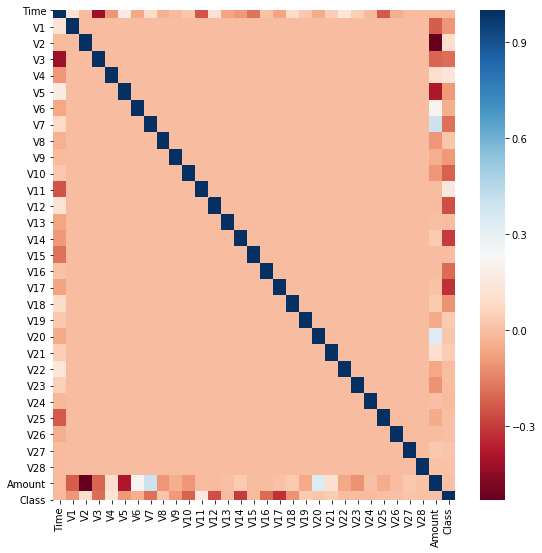

In [15]:
import seaborn as sns

plt.figure(figsize=(9,9))
corr = card_df.corr()
sns.heatmap(corr, cmap='RdBu')

### function for outlier data filtering

In [16]:
import numpy as np

def get_outlier(df=None, column=None, weight=1.5):
    fraud = df[df['Class']==1][column]
    quantile_25 = np.percentile(fraud.values, 25)
    quantile_75 = np.percentile(fraud.values, 75)
    
    iqr = quantile_75 - quantile_25
    iqr_weight = iqr * weight
    lowest_val = quantile_25 - iqr_weight
    highest_val = quantile_75 + iqr_weight
    
    outlier_index = fraud[(fraud > highest_val)|(fraud < lowest_val)].index
    
    return outlier_index



In [17]:
outlier_index = get_outlier(card_df,'V14', 1.5)
print(outlier_index)

type(outlier_index)

Int64Index([8296, 8615, 9035, 9252], dtype='int64')


pandas.core.indexes.numeric.Int64Index

In [18]:
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    
    # log1p = log(x + 1). to reverse, used np.expm1 (exp minus 1)
    amount_n = np.log1p(df_copy['Amount'])
    df_copy.insert(0, "Log_scaled_Amount", amount_n)
    df_copy.drop(['Amount', 'Time'], axis =1, inplace=True)
    
    outlier_index = get_outlier(card_df,'V14', 1.5)
    df_copy.drop(outlier_index, axis=0, inplace=True)
    
    return df_copy

X_train,X_test, y_train, y_test = get_train_test_dataset(card_df)

print('### LogisticRegression ###')

get_model_train_eval(lr_clf, X_train, X_test, y_train, y_test)

print('### LightGBM ###')

get_model_train_eval(lgbm_clf, X_train, X_test, y_train, y_test)

### LogisticRegression ###
confusion matrics
[[85281    14]
 [   48    98]]
accuracy: 0.9993, precision: 0.8750, recall: 0.6712, F1: 0.7597, AUC:0.9743
### LightGBM ###
confusion matrics
[[85291     4]
 [   25   121]]
accuracy: 0.9997, precision: 0.9680, recall: 0.8288, F1: 0.8930, AUC:0.9831


### SMOTE over-sampling

In [19]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=0)
X_train_over, y_train_over = smote.fit_sample(X_train, y_train)

print(X_train.shape, y_train.shape)
print(X_train_over.shape, y_train_over.shape)
print(pd.Series(y_train_over).value_counts())

(199362, 29) (199362,)
(398040, 29) (398040,)
1    199020
0    199020
Name: Class, dtype: int64


In [21]:
y_train.value_counts()

0    199020
1       342
Name: Class, dtype: int64

In [22]:
lr_clf = LogisticRegression()
get_model_train_eval(lr_clf, X_train_over, X_test, y_train_over, y_test)

confusion matrics
[[82937  2358]
 [   11   135]]
accuracy: 0.9723, precision: 0.0542, recall: 0.9247, F1: 0.1023, AUC:0.9737


In [23]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.metrics import precision_recall_curve
%matplotlib inline

def precision_recall_curve_plot(y_test , pred_proba_c1):
    # threshold ndarray,  precision and recall ndarray
    precisions, recalls, thresholds = precision_recall_curve( y_test, pred_proba_c1)
    
    # threshold on X axis, precision and recall on Y axis
    plt.figure(figsize=(8,6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary],label='recall')
    
    # change scale of X axis
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
    
    # plot settings
    plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
    plt.legend(); plt.grid()
    plt.show()

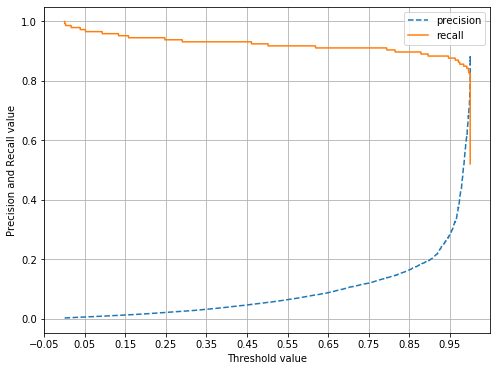

In [24]:
precision_recall_curve_plot(y_test, lr_clf.predict_proba(X_test)[:, 1])

In [25]:
get_model_train_eval(lgbm_clf, X_train_over, X_test, y_train_over, y_test)

confusion matrics
[[85286     9]
 [   22   124]]
accuracy: 0.9996, precision: 0.9323, recall: 0.8493, F1: 0.8889, AUC:0.9789
